# 1.Import Necessary Libraries

In [ ]:
!pip install --upgrade scikit-learn==1.3.0 scikeras xgboost tensorflow keras-tuner imbalanced-learn matplotlib seaborn

  Using cached scikeras-0.13.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
INFO: pip is looking at multiple versions of scikeras to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of imbalanced-learn to determine which version is compatible with other requirements. This could take a while.


In [ ]:
import sklearn
import xgboost
import tensorflow

print("sklearn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("tensorflow:", tensorflow.__version__)


sklearn: 1.3.0
xgboost: 2.1.3
tensorflow: 2.18.0


In [ ]:
#General Purpose Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
from sklearn.model_selection import train_test_split

#Machine Learning Libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc
)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#Keras and TensorFlow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')


# 2.Load and Inspect the Dataset

In [ ]:
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd
import numpy as np

# Load the dataset
file_path = '/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/Asteroid Collision Dataset V2.csv'
df = pd.read_csv(file_path, low_memory=False)

# Inspect the dataset
print("Dataset Shape:", df.shape)
print("First 5 Rows:\n", df.head())


Mounted at /content/drive
Dataset Shape: (677494, 79)
First 5 Rows:
    diameter  extent  albedo  rot_per  GM  BV  UB  IR spec_B  spec_T  ...  \
0       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
1       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
2       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
3       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
4       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   

        rms  two_body  A1  A1_sigma  A2  A2_sigma  A3  A3_sigma  DT  DT_sigma  
0  0.000533       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
1  0.071263       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
2  0.000002       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
3       NaN         T NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
4  0.339380       NaN NaN       NaN NaN       NaN NaN       NaN NaN       

# 3.Initial EDA


--- Initial EDA (Before Preprocessing) ---

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677494 entries, 0 to 677493
Data columns (total 79 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   diameter        6866 non-null    float64
 1   extent          0 non-null       float64
 2   albedo          6500 non-null    float64
 3   rot_per         1347 non-null    float64
 4   GM              0 non-null       float64
 5   BV              0 non-null       float64
 6   UB              0 non-null       float64
 7   IR              0 non-null       float64
 8   spec_B          50 non-null      object 
 9   spec_T          0 non-null       float64
 10  full_name       677494 non-null  object 
 11  a               677494 non-null  float64
 12  e               677494 non-null  float64
 13  i               677494 non-null  float64
 14  om              677494 non-null  float64
 15  w               677494 non-null  float64


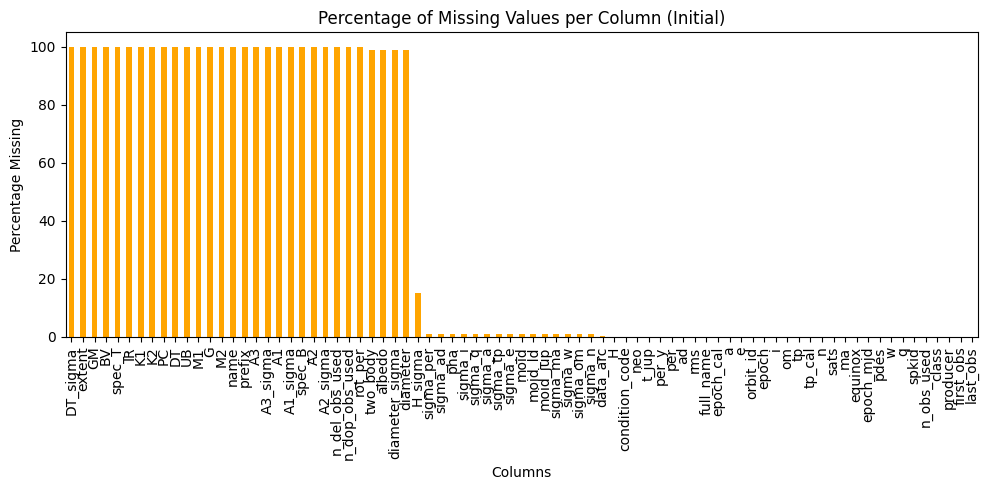

In [ ]:
print("\n--- Initial EDA (Before Preprocessing) ---")
# Basic Info
print("\nDataframe Info:")
df.info()

# Statistical Summary
print("\nStatistical Summary of Numeric Columns:")
print(df.describe(include=[np.number]))

# Check missing values again visually
missing_summary = df.isnull().mean().sort_values(ascending=False)*100
print("\nMissing Data Summary (Percentage of Missing Values):\n", missing_summary)

# Plot Missing Values
plt.figure(figsize=(10,5))
missing_summary.plot(kind='bar', color='orange')
plt.title('Percentage of Missing Values per Column (Initial)')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.tight_layout()
plt.show()

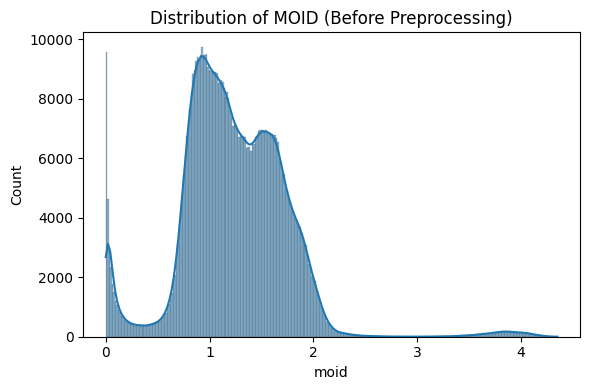

In [ ]:
# Distribution of MOID (Before Preprocessing)
if 'moid' in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df['moid'], kde=True)
    plt.title('Distribution of MOID (Before Preprocessing)')
    plt.tight_layout()
    plt.show()

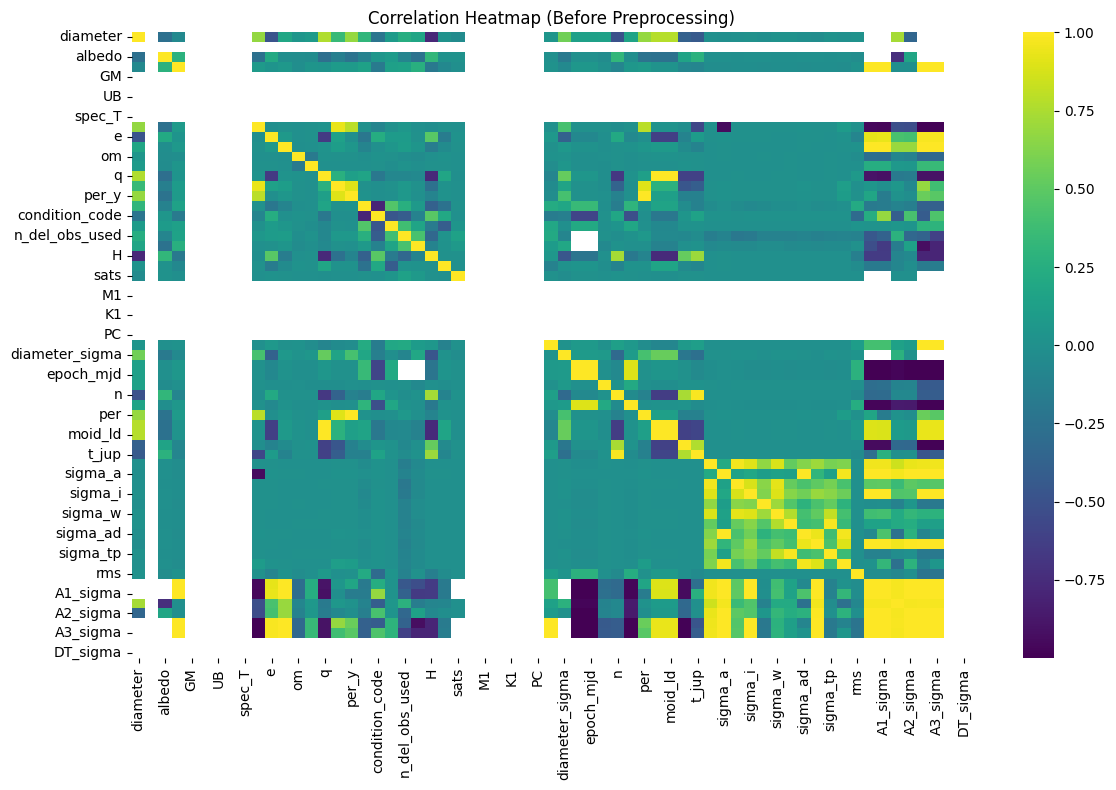

In [ ]:
# Correlation Heatmap (Initial)
numeric_cols_initial = df.select_dtypes(include=[np.number]).columns
corr_initial = df[numeric_cols_initial].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_initial, annot=False, cmap='viridis')
plt.title('Correlation Heatmap (Before Preprocessing)')
plt.tight_layout()
plt.show()

# 4.Data Preprocessing

## 4.1. Handle Missing Data

In [ ]:
# Analyze missing data
missing_summary = df.isnull().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary[missing_summary > 0]
print("\nMissing Data Summary (Percentage of Missing Values):")
print(missing_summary)

# Drop columns with >90% missing values or irrelevant
cols_to_drop_missing = missing_summary[missing_summary > 90].index.tolist()
irrelevant_columns = ['producer', 'equinox', 'orbit_id', 'pdes', 'full_name', 'name', 'prefix']
cols_to_drop = list(set(cols_to_drop_missing + irrelevant_columns))

cols_to_drop = [col for col in cols_to_drop if col in df.columns]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print("\nDropped Columns:")
print(cols_to_drop)


Missing Data Summary (Percentage of Missing Values):
DT_sigma          100.000000
extent            100.000000
GM                100.000000
BV                100.000000
spec_T            100.000000
IR                100.000000
K1                100.000000
K2                100.000000
PC                100.000000
DT                100.000000
UB                100.000000
M1                100.000000
G                 100.000000
M2                100.000000
name               99.999852
prefix             99.999410
A3                 99.998967
A3_sigma           99.998967
A1                 99.997491
A1_sigma           99.997491
spec_B             99.992620
A2                 99.976531
A2_sigma           99.976531
n_del_obs_used     99.910700
n_dop_obs_used     99.910700
rot_per            99.801179
two_body           99.062427
albedo             99.040582
diameter_sigma     98.987002
diameter           98.986559
H_sigma            15.064635
sigma_per           0.937868
sigma_ad          

## 4.2. Impute missing values in numeric columns

In [ ]:
# Impute missing values in numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

## 4.3. Map Binary Columns

In [ ]:
# Map 'Y'/'N' to 1/0 in binary columns
binary_mapping = {'Y': 1, 'N': 0}
for col in ['neo', 'pha']:
    if col in df.columns:
        df[col] = df[col].map(binary_mapping)

## 4.4. Handle Date Columns

In [ ]:
# Convert date columns to datetime and extract year, month, day
date_cols = ['epoch_cal', 'tp_cal', 'first_obs', 'last_obs']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', format='%Y-%m-%d')
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df.drop(columns=[col], inplace=True)

In [ ]:
df.shape

(677494, 52)

## 4.5. One-Hot Encode Categorical Columns

In [ ]:
# Identify remaining categorical columns
remaining_categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nRemaining Categorical Columns after Date conversion:", remaining_categorical_cols)

# One-hot encode the 'class' column if it exists
if 'class' in df.columns:
    df = pd.get_dummies(df, columns=['class'], prefix='class', drop_first=True)


Remaining Categorical Columns after Date conversion: ['class']


# 5.Feature Engineering

## 5.1. Add Derived Features

In [ ]:
GRAVITATIONAL_CONSTANT = 39.478  # AU^3 / yr^2

# Add derived features
df['relative_orbital_distance'] = np.abs(df['q'] - df['a'] * (1 - df['e']))
df['orbital_velocity'] = np.sqrt(GRAVITATIONAL_CONSTANT / df['a'])
df['adjusted_eccentricity'] = df['e'] * df['a'] / df['q']

## 5.2. Add Perturbed Features

In [ ]:
# Perturb orbital elements based on their uncertainties
for col in ['a', 'e', 'q', 'i']:
    sigma_col = f'sigma_{col}'
    if sigma_col in df.columns:
        df[f'{col}_perturbed'] = df[col] + np.random.normal(0, df[sigma_col])

## 5.3. Create Target Variable

In [ ]:
# Create 'collision_risk' based on 'moid' (Minimum Orbit Intersection Distance)
df['collision_risk'] = np.where(df['moid'] < 0.05, 1, 0)

# Drop 'moid' and 'moid_ld' from features
features_to_drop = ['moid', 'moid_ld']
df.drop(columns=features_to_drop, inplace=True, errors='ignore')

# 6.Prepare Data for Modeling

## 6.1. Define Features and Target

In [ ]:
# Define features and target variable
X = df.drop(columns=['collision_risk'])
y = df['collision_risk']

# Ensure only numeric features are used
X = X.select_dtypes(include=[np.number])

## 6.2. Split the Dataset

In [ ]:
# Split the dataset with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 6.3. Handle Missing Values in Training and Testing Sets

In [ ]:
# Identify columns with all missing values and drop them
all_missing_cols = X_train.columns[X_train.isnull().all()]
print("Columns with all missing values:", all_missing_cols.tolist())

X_train.drop(columns=all_missing_cols, inplace=True)
X_test.drop(columns=all_missing_cols, inplace=True)

# Re-impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Verify no missing values remain
print("Missing Values in X_train:", X_train.isnull().sum().sum())
print("Missing Values in X_test:", X_test.isnull().sum().sum())

Columns with all missing values: ['epoch_cal_year', 'epoch_cal_month', 'epoch_cal_day', 'tp_cal_year', 'tp_cal_month', 'tp_cal_day']
Missing Values in X_train: 0
Missing Values in X_test: 0


## 6.4. Handle Class Imbalance with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled Training Set Shape:", X_train_resampled.shape)
print("Class Distribution After Resampling:\n", y_train_resampled.value_counts())

Resampled Training Set Shape: (1054508, 50)
Class Distribution After Resampling:
 collision_risk
0    527254
1    527254
Name: count, dtype: int64


In [ ]:
print("Missing Values in the Entire Dataset:\n", df.isnull().sum())

Missing Values in the Entire Dataset:
 a                 0
e                 0
i                 0
om                0
w                 0
                 ..
a_perturbed       0
e_perturbed       0
q_perturbed       0
i_perturbed       0
collision_risk    0
Length: 66, dtype: int64


## 6.5. Data Scaling

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

## 6.6 Save feature names

In [ ]:
# Save feature names from the training data
feature_names = X_train_resampled.columns.tolist()  # Extract feature names as a list
feature_names_path = "/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/feature_names.pkl"

# Save the feature names to a file
joblib.dump(feature_names, feature_names_path)

print(f"Feature names saved to: {feature_names_path}")


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
# Load the saved feature names
loaded_feature_names = joblib.load(feature_names_path)
print("Loaded Feature Names:", loaded_feature_names)

Loaded Feature Names: ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'condition_code', 'n_obs_used', 'H', 'spkid', 'neo', 'pha', 'sats', 'H_sigma', 'epoch', 'epoch_mjd', 'ma', 'n', 'tp', 'per', 'moid_jup', 't_jup', 'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w', 'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'rms', 'first_obs_year', 'first_obs_month', 'first_obs_day', 'last_obs_year', 'last_obs_month', 'last_obs_day', 'relative_orbital_distance', 'orbital_velocity', 'adjusted_eccentricity', 'a_perturbed', 'e_perturbed', 'q_perturbed', 'i_perturbed']


# 7.Secondary EDA


--- Secondary EDA (After Preprocessing) ---
Post-Preprocessing X_train_resampled_scaled shape: (1054508, 50)
Class Distribution in y_train_resampled:
 collision_risk
0    527254
1    527254
Name: count, dtype: int64


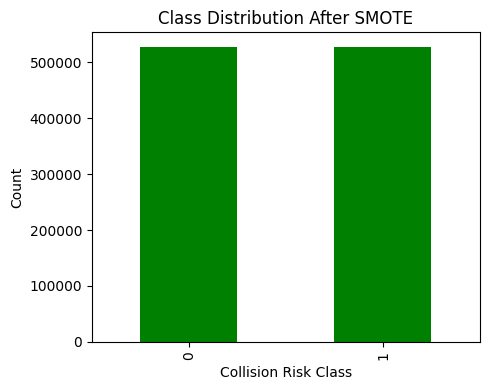

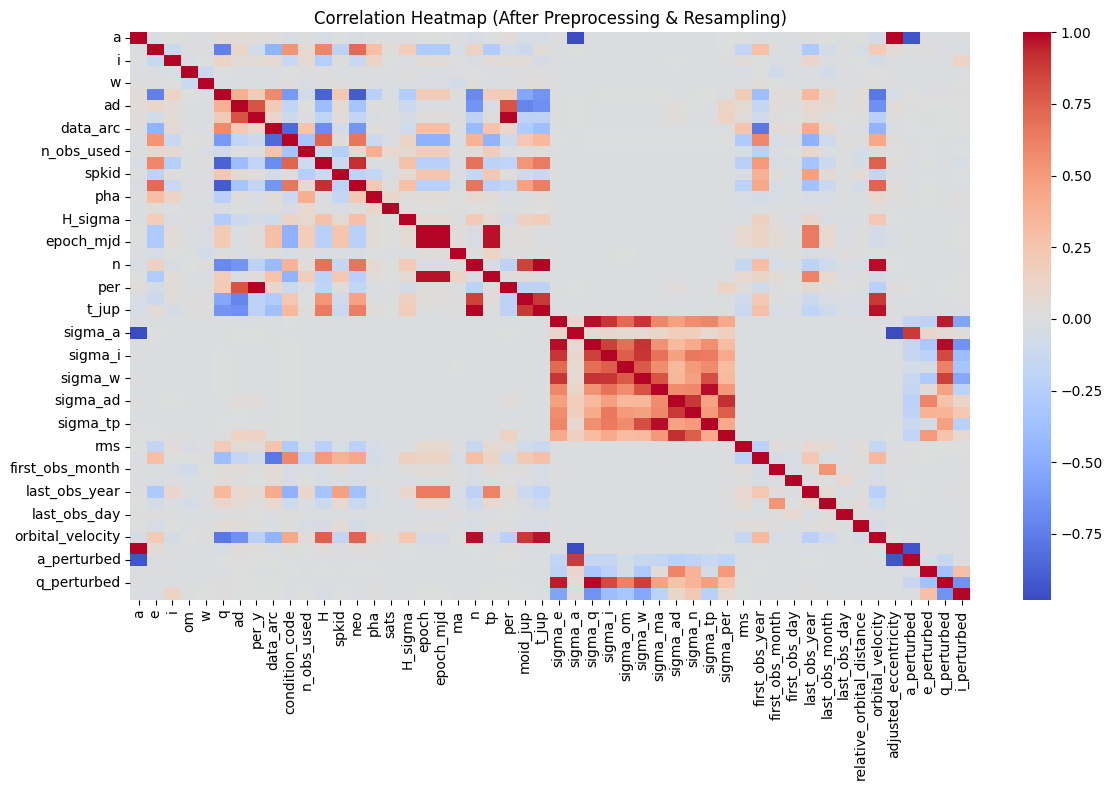

In [ ]:
print("\n--- Secondary EDA (After Preprocessing) ---")

# Check the shape and distribution again
print("Post-Preprocessing X_train_resampled_scaled shape:", X_train_resampled_scaled.shape)
print("Class Distribution in y_train_resampled:\n", y_train_resampled.value_counts())

# Plot class distribution after SMOTE
plt.figure(figsize=(5,4))
y_train_resampled.value_counts().plot(kind='bar', color='green')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Collision Risk Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Correlation heatmap after preprocessing (use the X_train after imputation/dropping)
X_train_post = pd.DataFrame(X_train_resampled_scaled, columns=X_train.columns)
corr_post = pd.DataFrame(X_train_post, columns=X_train.columns).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_post, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (After Preprocessing & Resampling)')
plt.tight_layout()
plt.show()

# 8.Model Training and Evaluation

In [ ]:
save_dir = "/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics"

## 8.1 Random Forest Classifier

### 8.1.1 Training the Random Forest

In [ ]:

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_resampled_scaled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [ ]:
# Save the model
rf_model_path = "/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/random_forest_model.pkl"
joblib.dump(rf_model, rf_model_path)
print(f"Random Forest model saved at: {rf_model_path}")

Random Forest model saved at: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/random_forest_model.pkl


### 8.1.2 Predictions and Evaluation


Random Forest Evaluation Metrics:
Accuracy: 0.9800072325257013
F1 Score: 0.43290768264601215
Precision: 0.9468864468864469
Recall: 0.28059701492537314
ROC-AUC: 0.9985165540712264


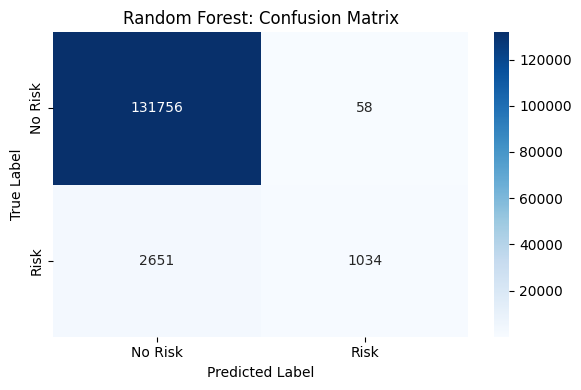

In [ ]:
# Predict on test data
rf_y_pred = rf_model.predict(X_test_scaled)
rf_y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_roc_auc = roc_auc_score(y_test, rf_y_prob)

print("\nRandom Forest Evaluation Metrics:")
print(f"Accuracy: {rf_accuracy}")
print(f"F1 Score: {rf_f1}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"ROC-AUC: {rf_roc_auc}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.title('Random Forest: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


## 8.2 XGBoost Classifier

### 8.2.1 Training the XGBoost Model

In [ ]:
import xgboost
print(xgboost.__version__)


2.1.3


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Initialize XGBoost
xgb_model = XGBClassifier(
    use_label_encoder=False,  # Suppress unnecessary warnings
    random_state=42,
    eval_metric='logloss',    # Specify evaluation metric
    n_estimators=500          # Specify the number of boosting rounds
)

# Train the model
xgb_model.fit(
    X_train_resampled_scaled,
    y_train_resampled,
    verbose=True  # Display training progress
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Save the model
xgb_model_path = "/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/xgboost_model.pkl"
joblib.dump(xgb_model, xgb_model_path)
print(f"XGBoost model saved at: {xgb_model_path}")

XGBoost model saved at: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/xgboost_model.pkl


### 8.2.2 Predictions and Evaluation


XGBoost Evaluation Metrics:
Accuracy: 0.9969520070258822
F1 Score: 0.9453052575817773
Precision: 0.9231764097258148
Recall: 0.9685210312075984
ROC-AUC: 0.9997514846533784


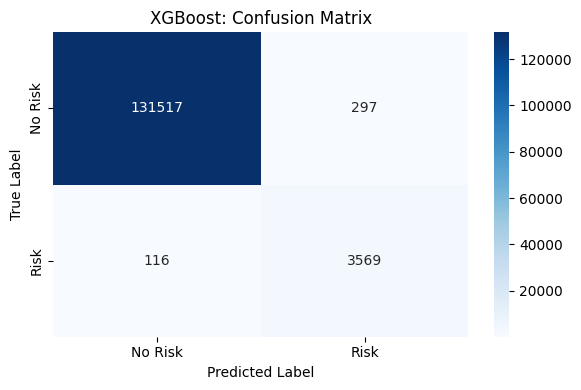

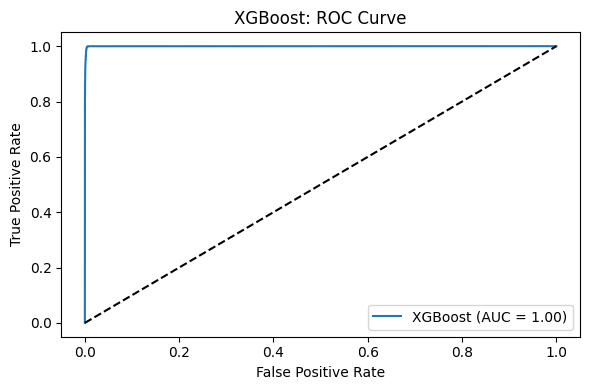

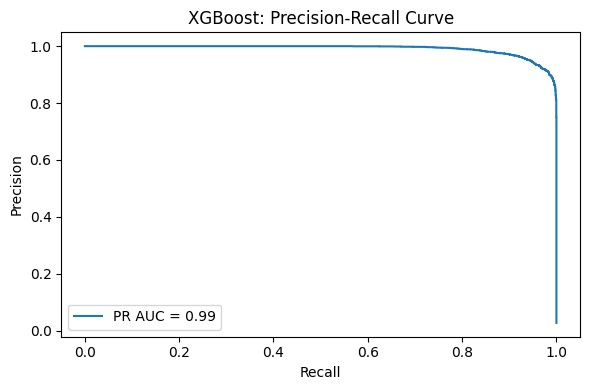

In [ ]:
# Predict on test data
xgb_y_pred = xgb_model.predict(X_test_scaled)
xgb_y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_y_prob)

print("\nXGBoost Evaluation Metrics:")
print(f"Accuracy: {xgb_accuracy}")
print(f"F1 Score: {xgb_f1}")
print(f"Precision: {xgb_precision}")
print(f"Recall: {xgb_recall}")
print(f"ROC-AUC: {xgb_roc_auc}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.title('XGBoost: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## 8.3 Custom Neural Network(Dense)

### 8.3.1 Defining the Model

In [ ]:
# Define the custom model
def create_dense_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

### 8.3.2 Training the Neural Network

In [ ]:
# Initialize the model
dense_model = create_dense_model(X_train_resampled_scaled.shape[1])

# Set Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with Early Stopping
history = dense_model.fit(
    X_train_resampled_scaled,
    y_train_resampled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9911 - loss: 0.0304 - val_accuracy: 0.9995 - val_loss: 0.0067
Epoch 2/50
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9950 - loss: 0.0170 - val_accuracy: 0.9996 - val_loss: 0.0082
Epoch 3/50
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9954 - loss: 0.0162 - val_accuracy: 0.9994 - val_loss: 0.0154
Epoch 4/50
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.9957 - loss: 0.0149 - val_accuracy: 0.9996 - val_loss: 0.0062
Epoch 5/50
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9958 - loss: 0.0169 - val_accuracy: 0.9994 - val_loss: 0.0087
Epoch 6/50
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9959 - loss: 0.0147 - val_accuracy: 0.9997 - val_loss: 0.0054
Epoch 7/50
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9960 - loss: 0.0144 - val_accuracy: 0.9999 - val_loss: 0.0046
Epoch 8/50
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 

In [ ]:
#Save Neural Network
dense_model_filename = os.path.join(save_dir, "dense_model.h5")
dense_model.save(dense_model_filename)
print(f"Neural Network model saved to: {dense_model_filename}")

Neural Network model saved to: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/dense_model.h5


### 8.3.4. Evaluation on Test Set

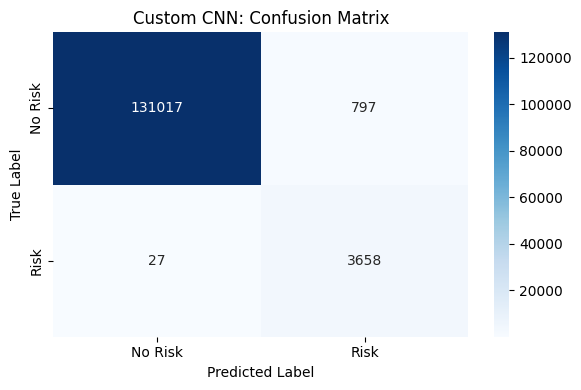

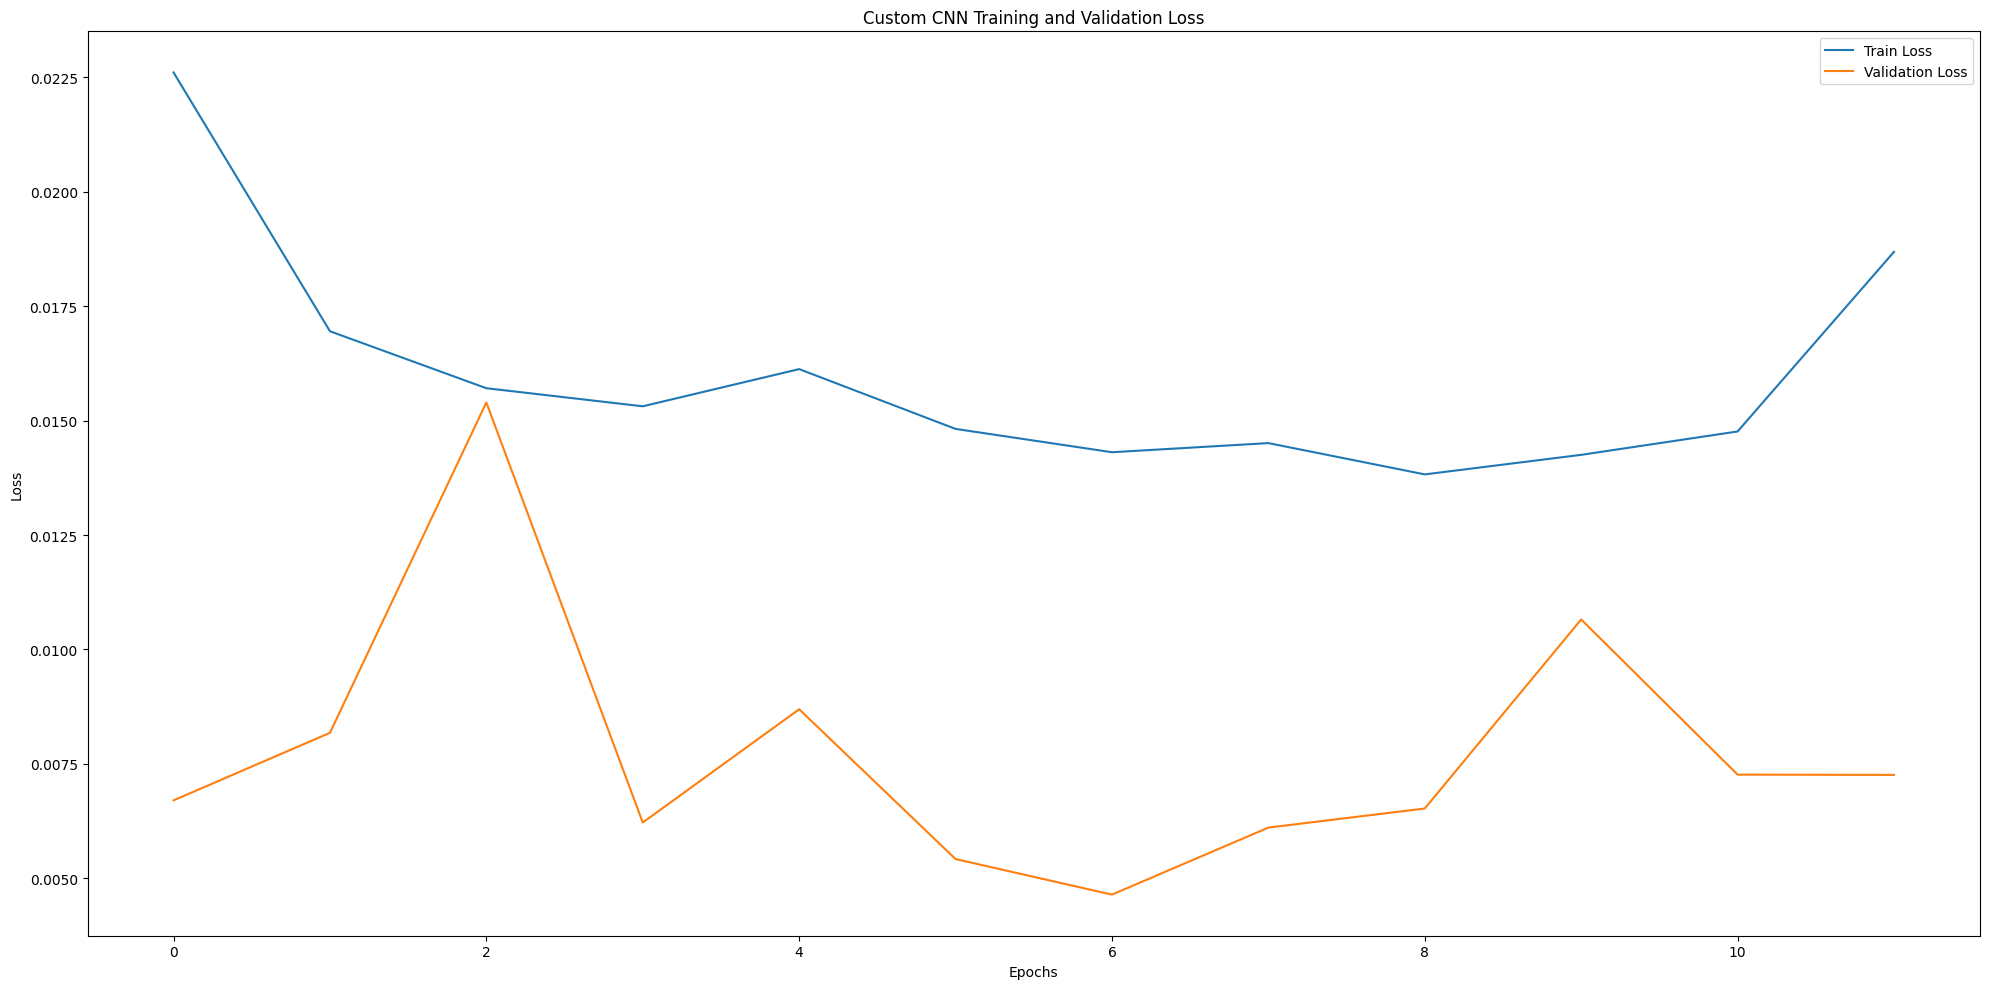

In [ ]:
# Predict probabilities and binary predictions
dense_y_prob = dense_model.predict(X_test_scaled).flatten()
dense_y_pred = (dense_y_prob > 0.5).astype(int)

# Evaluate the model
dense_accuracy = accuracy_score(y_test, dense_y_pred)
dense_f1 = f1_score(y_test, dense_y_pred)
dense_precision = precision_score(y_test, dense_y_pred)
dense_recall = recall_score(y_test, dense_y_pred)
dense_roc_auc = roc_auc_score(y_test, dense_y_prob)

print("\nCustom CNN Evaluation Metrics:")
print(f"Accuracy: {dense_accuracy}")
print(f"F1 Score: {dense_f1}")
print(f"Precision: {dense_precision}")
print(f"Recall: {dense_recall}")
print(f"ROC-AUC: {dense_roc_auc}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, dense_y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.title('Custom CNN: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Plot Training History
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Custom CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 9.Model Comparison

## 9.1 Visualization

In [ ]:
# Collect metrics for each model
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Custom CNN'],
    'Accuracy': [rf_accuracy, xgb_accuracy, dense_accuracy],
    'F1 Score': [rf_f1, xgb_f1, dense_f1],
    'Precision': [rf_precision, xgb_precision, dense_precision],
    'Recall': [rf_recall, xgb_recall, dense_recall],
    'ROC-AUC': [rf_roc_auc, xgb_roc_auc, dense_roc_auc]
})

# Display the metrics
print(metrics_df)

           Model  Accuracy  F1 Score  Precision    Recall   ROC-AUC
0  Random Forest  0.980007  0.432908   0.946886  0.280597  0.998517
1        XGBoost  0.996952  0.945305   0.923176  0.968521  0.999751
2     Custom CNN  0.993919  0.898771   0.821100  0.992673  0.999447


In [ ]:
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


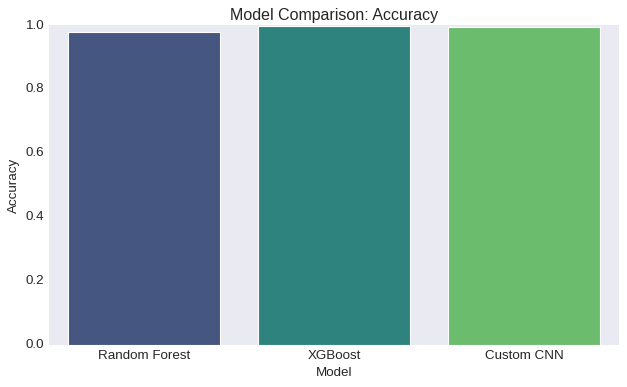

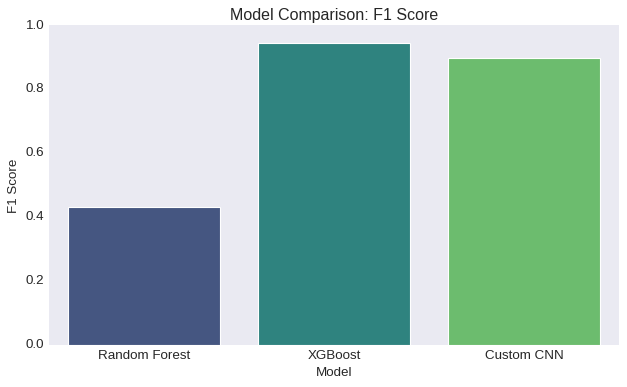

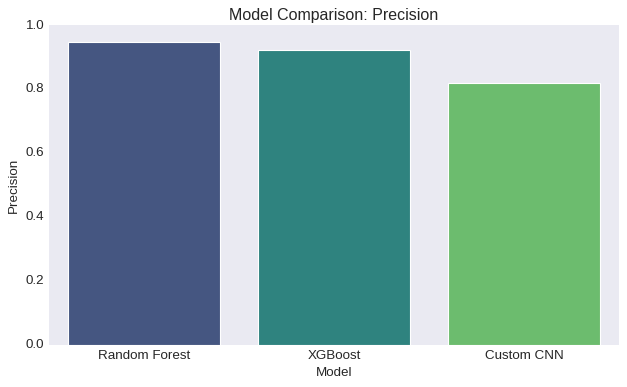

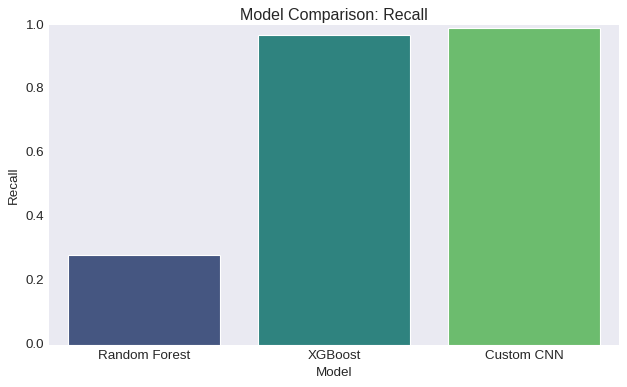

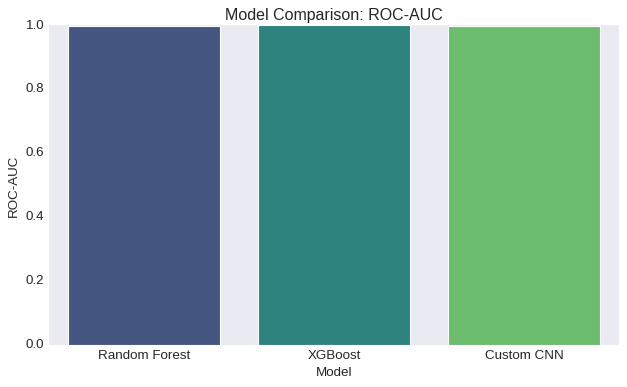

In [ ]:
# Set plot style
plt.style.use('seaborn-v0_8-dark')

# Plot metrics comparison
metrics_to_plot = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC-AUC']

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')
    plt.title(f'Model Comparison: {metric}')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

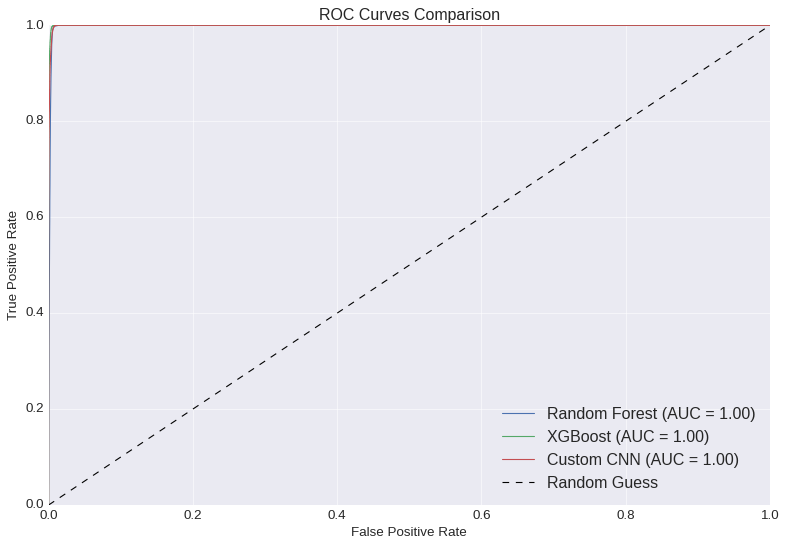

In [ ]:
# Plot ROC Curves
plt.figure(figsize=(10, 7))

# Random Forest ROC
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_prob)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f})')

# XGBoost ROC
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_prob)
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_roc_auc:.2f})')

# Custom CNN ROC
dense_fpr, dense_tpr, _ = roc_curve(y_test, dense_y_prob)
plt.plot(dense_fpr, dense_tpr, label=f'Custom CNN (AUC = {dense_roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


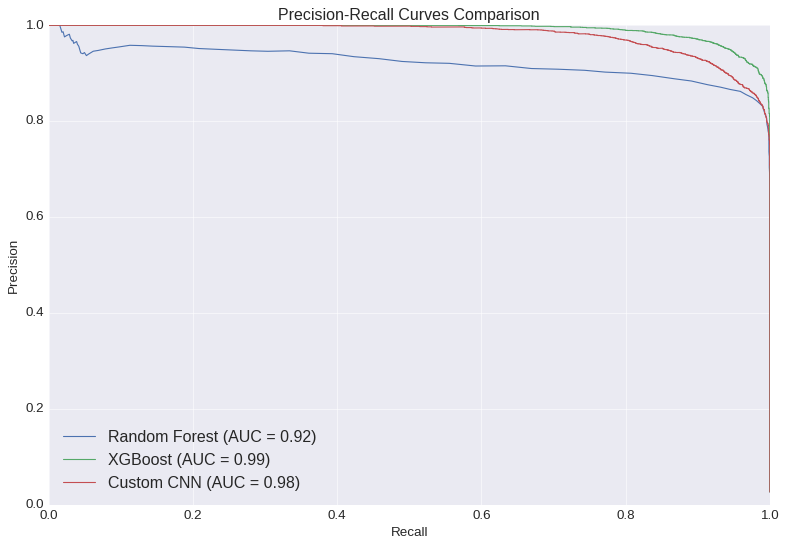

In [ ]:
# Plot Precision-Recall Curves
plt.figure(figsize=(10, 7))

# Random Forest PR Curve
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_y_prob)
plt.plot(rf_recall, rf_precision, label=f'Random Forest (AUC = {auc(rf_recall, rf_precision):.2f})')

# XGBoost PR Curve
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_y_prob)
plt.plot(xgb_recall, xgb_precision, label=f'XGBoost (AUC = {auc(xgb_recall, xgb_precision):.2f})')

# Custom CNN PR Curve
dense_precision, dense_recall, _ = precision_recall_curve(y_test, dense_y_prob)
plt.plot(dense_recall, dense_precision, label=f'Custom CNN (AUC = {auc(dense_recall, dense_precision):.2f})')

# Plot settings
plt.title('Precision-Recall Curves Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()

## 9.2 Feature Importance Comparison

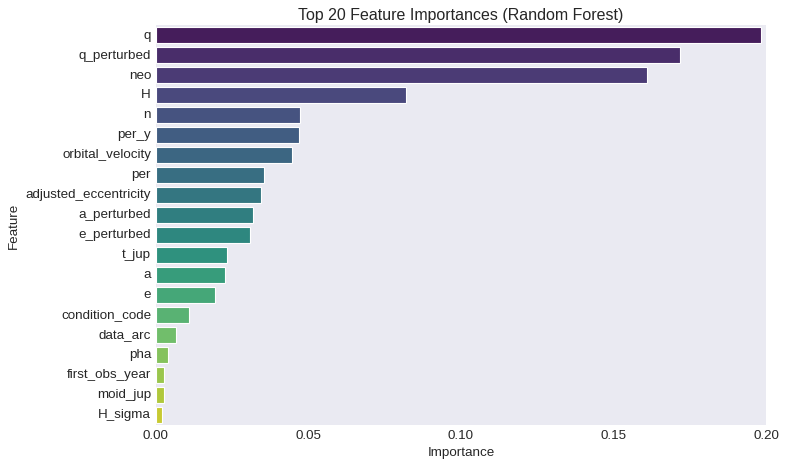

In [ ]:
# Feature Importance Random Forest
importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

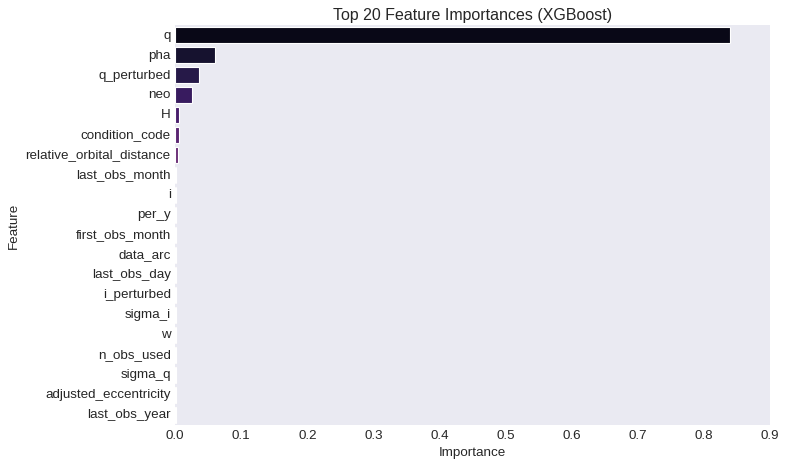

In [ ]:
# Feature Importance XGBoost
xgb_importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='magma')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 9.3 SHAP (SHapley Additive exPlanations) for Custom CNN

In [ ]:
#load feature names
try:
    loaded_feature_names = joblib.load(feature_names_path)
    print(f"Feature names loaded successfully from: {feature_names_path}")
    print(f"Loaded Feature Names: {loaded_feature_names[:10]}...")  # Display the first 10
except Exception as e:
    print(f"Error loading feature names: {e}")

Feature names loaded successfully from: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/feature_names.pkl
Loaded Feature Names: ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'condition_code']...


In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=63ad51a37acb2c50d3c60a27d8316c2ae8aebcb308bd083eabd4e2393a1a5a83
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
from lime.lime_tabular import LimeTabularExplainer

def cnn_predict(data):
    """
    A function to output probabilities for both classes (No Collision Risk and Collision Risk).
    """
    class_1_prob = dense_model.predict(data).flatten()  # Probability for Collision Risk
    class_0_prob = 1 - class_1_prob                     # Probability for No Collision Risk
    return np.column_stack((class_0_prob, class_1_prob))  # Combine into (N, 2) shape


# Initialize LIME Explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_resampled_scaled,  # Use the scaled training data
    mode="classification",                  # Specify classification mode
    feature_names=loaded_feature_names,     # Feature names from the dataset
    class_names=["No Collision Risk", "Collision Risk"],  # Class labels
    discretize_continuous=True              # Discretize continuous variables
)


In [ ]:
# Select an instance from the test data
instance_to_explain = X_test_scaled[0]

# Explain the instance
lime_explanation = lime_explainer.explain_instance(
    data_row=instance_to_explain,  # Instance to explain
    predict_fn=cnn_predict,        # Prediction function
    num_features=10                # Number of features to display
)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


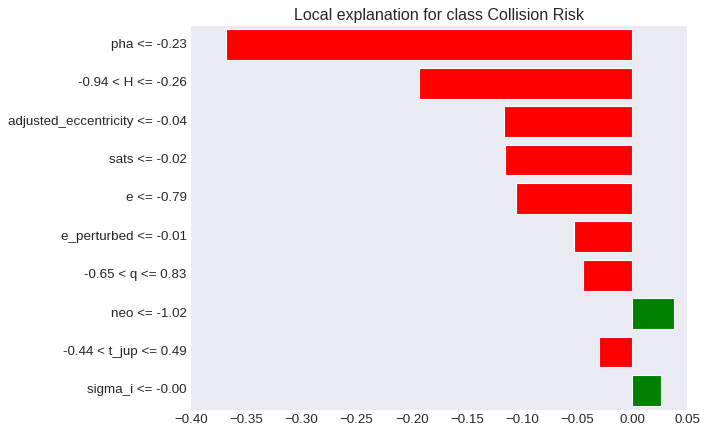

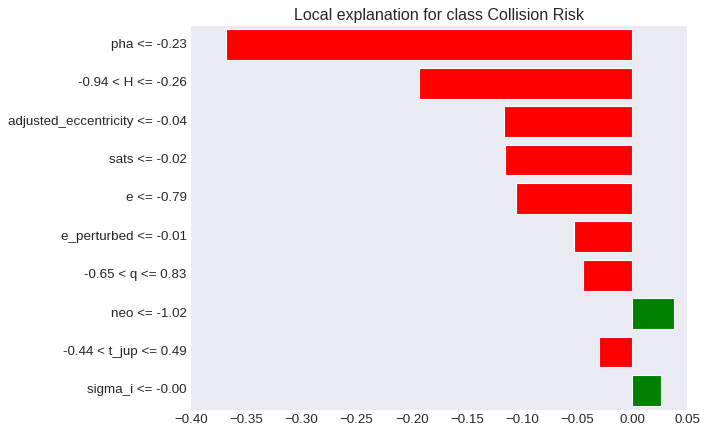

In [ ]:
# Visualize explanation as a bar plot
lime_explanation.as_pyplot_figure()

# 12.Monte Carlo Simulation with Edge Cases

In [ ]:
import joblib
from tensorflow.keras.models import load_model

# Define save directory
save_dir = "/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics"

# Load Random Forest model
rf_model_path = f"{save_dir}/random_forest_model.pkl"
rf_model = joblib.load(rf_model_path)
print("Random Forest model loaded.")

# Load XGBoost model
xgb_model_path = f"{save_dir}/xgboost_model.pkl"
xgb_model = joblib.load(xgb_model_path)
print("XGBoost model loaded.")

# Load Neural Network model
nn_model_path = f"{save_dir}/dense_model.h5"
nn_model = load_model(nn_model_path)
print("Neural Network model loaded.")

# Verify successful loading
print("All models loaded successfully!")


Random Forest model loaded.
XGBoost model loaded.
Neural Network model loaded.
All models loaded successfully!


## 12.1 Generate Edge Case Data

In [ ]:
def monte_carlo_extended_cases(model, X_test, feature_columns, n_simulations=100):
    """
    Monte Carlo Simulation with Extended Edge Cases.

    Parameters:
    - model: Trained model for predictions
    - X_test: Test data (scaled as NumPy array)
    - feature_columns: List of feature names in the dataset
    - n_simulations: Number of simulations for each edge case

    Returns:
    - Results: Dictionary of predictions for each edge case
    """
    # Convert X_test to DataFrame
    X_test_df = pd.DataFrame(X_test, columns=feature_columns)

    # Initialize results dictionary
    results = {}

    # Extended Edge Cases
    extended_conditions = {
        "low_moid": lambda df: df.assign(moid=0.001 if 'moid' in df.columns else 0),  # Near-zero MOID
        "high_moid": lambda df: df.assign(moid=10.0 if 'moid' in df.columns else 0),  # Very high MOID
        "near_parabolic_orbit": lambda df: df.assign(e=0.999 if 'e' in df.columns else 0),  # Near-parabolic orbit
        "low_semi_major_axis": lambda df: df.assign(a=0.1 if 'a' in df.columns else 0),  # Very small semi-major axis
        "high_semi_major_axis": lambda df: df.assign(a=100.0 if 'a' in df.columns else 0),  # Extremely large semi-major axis
        "low_periapsis_distance": lambda df: df.assign(q=0.05 if 'q' in df.columns else 0),  # Close periapsis
        "high_periapsis_distance": lambda df: df.assign(q=10.0 if 'q' in df.columns else 0),  # Distant periapsis
        "long_observation_arc": lambda df: df.assign(arc_length=50000 if 'arc_length' in df.columns else 0),  # Long observation arc
        "high_uncertainty": lambda df: df.assign(
            sigma_a=df['a'] * 0.5 if 'a' in df.columns else 0,
            sigma_e=df['e'] * 0.5 if 'e' in df.columns else 0,
            sigma_i=df['i'] * 0.5 if 'i' in df.columns else 0
        ),  # High uncertainties
    }

    for condition, modifier in extended_conditions.items():
        simulated_data = []
        for _ in range(n_simulations):
            try:
                # Apply the condition modifier
                perturbed_data = modifier(X_test_df).copy()
                print(f"Condition '{condition}': Modifier applied successfully.")  # Debug
            except KeyError as e:
                print(f"KeyError for condition '{condition}': {e}. Skipping.")
                continue
            except Exception as e:
                print(f"Unexpected error for condition '{condition}': {e}. Skipping.")
                continue

            # Ensure perturbed data matches the original feature set
            perturbed_data = perturbed_data[feature_columns]  # Select only original features

            # Add random noise for perturbation
            for col in feature_columns:
                perturbation = np.random.normal(0, 0.01 * perturbed_data[col].std())
                perturbed_data[col] += perturbation

            # Predict probabilities
            try:
                y_prob = model.predict_proba(perturbed_data)[:, 1]
                simulated_data.append(y_prob)
            except Exception as e:
                print(f"Error during prediction for condition '{condition}': {e}")
                continue

        # Store results for the edge case
        if simulated_data:  # Avoid storing empty results
            results[condition] = pd.DataFrame(simulated_data).T

    return results




## 12.2 Perform Monte Carlo Simulations

### 12.2.1 Random Forest Simulation

Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied success

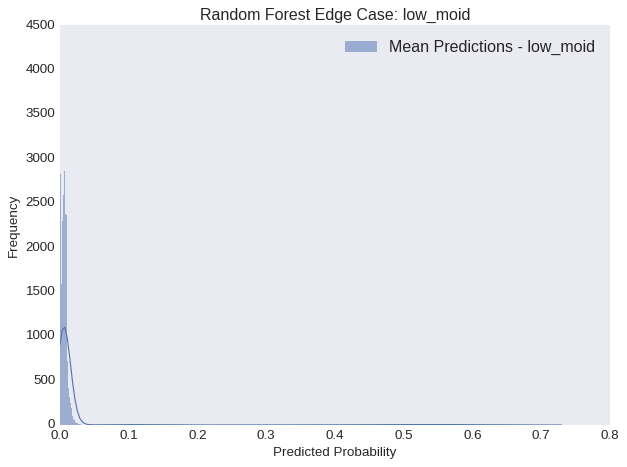


Random Forest Edge Case: high_moid
Mean Predictions: count    135499.000000
mean          0.025830
std           0.094111
min           0.000000
25%           0.002900
50%           0.006100
75%           0.010100
max           0.749200
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.020301
std           0.025464
min           0.000000
25%           0.010978
50%           0.015728
75%           0.020055
max           0.227860
dtype: float64


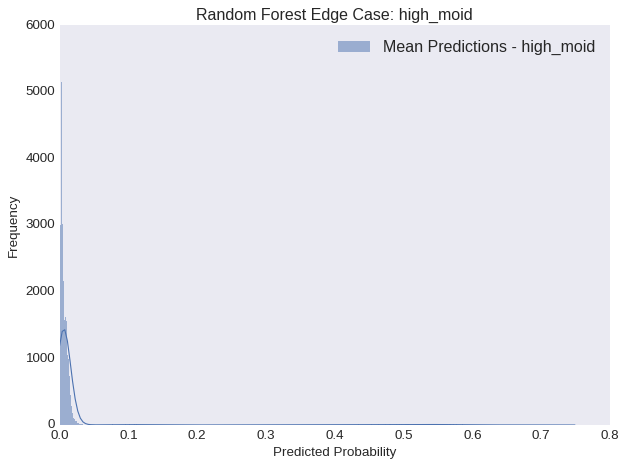


Random Forest Edge Case: near_parabolic_orbit
Mean Predictions: count    135499.000000
mean          0.025703
std           0.091876
min           0.000000
25%           0.002800
50%           0.005700
75%           0.009400
max           0.752000
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.017129
std           0.025354
min           0.000000
25%           0.006735
50%           0.012910
75%           0.017057
max           0.220752
dtype: float64


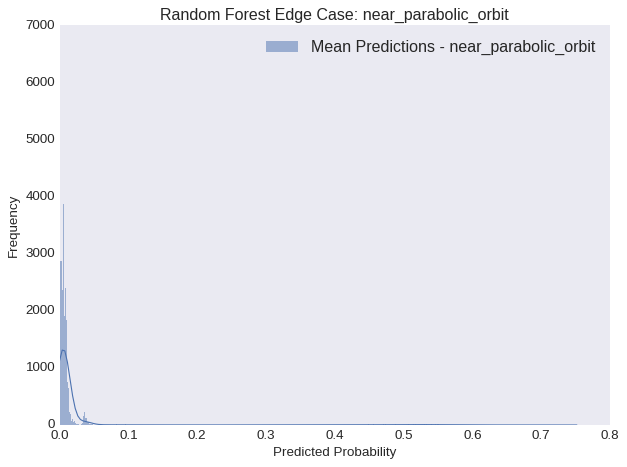


Random Forest Edge Case: low_semi_major_axis
Mean Predictions: count    135499.000000
mean          0.025703
std           0.089874
min           0.000000
25%           0.003900
50%           0.006300
75%           0.009300
max           0.727500
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.020756
std           0.022365
min           0.000000
25%           0.012969
50%           0.016722
75%           0.020523
max           0.203452
dtype: float64


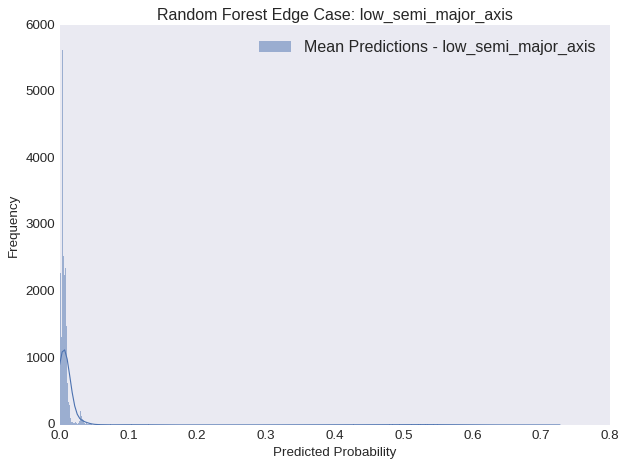


Random Forest Edge Case: high_semi_major_axis
Mean Predictions: count    135499.000000
mean          0.025275
std           0.088170
min           0.000000
25%           0.002900
50%           0.006500
75%           0.009600
max           0.727600
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.019854
std           0.022493
min           0.000000
25%           0.009713
50%           0.016765
75%           0.020547
max           0.197076
dtype: float64


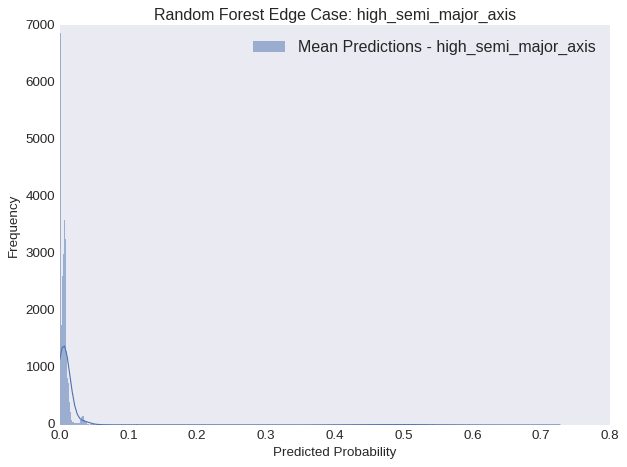


Random Forest Edge Case: low_periapsis_distance
Mean Predictions: count    135499.000000
mean          0.017163
std           0.042387
min           0.000000
25%           0.004800
50%           0.008300
75%           0.011800
max           0.571500
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.023003
std           0.012975
min           0.000000
25%           0.016761
50%           0.020714
75%           0.025134
max           0.134671
dtype: float64


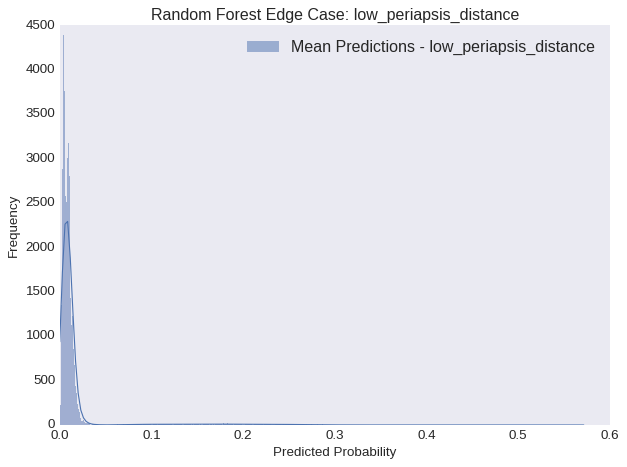


Random Forest Edge Case: high_periapsis_distance
Mean Predictions: count    135499.000000
mean          0.016720
std           0.041697
min           0.000000
25%           0.005900
50%           0.008500
75%           0.010600
max           0.572300
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.020350
std           0.013101
min           0.000000
25%           0.015509
50%           0.018407
75%           0.021096
max           0.140193
dtype: float64


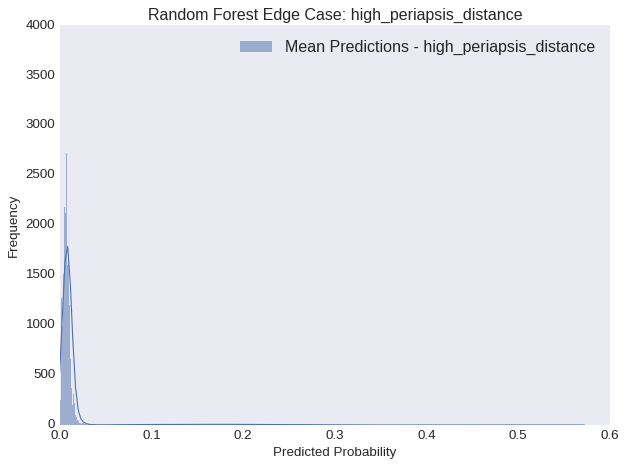


Random Forest Edge Case: long_observation_arc
Mean Predictions: count    135499.000000
mean          0.024111
std           0.089514
min           0.000000
25%           0.003400
50%           0.005800
75%           0.007800
max           0.735500
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.019247
std           0.024039
min           0.000000
25%           0.011229
50%           0.015129
75%           0.017746
max           0.229136
dtype: float64


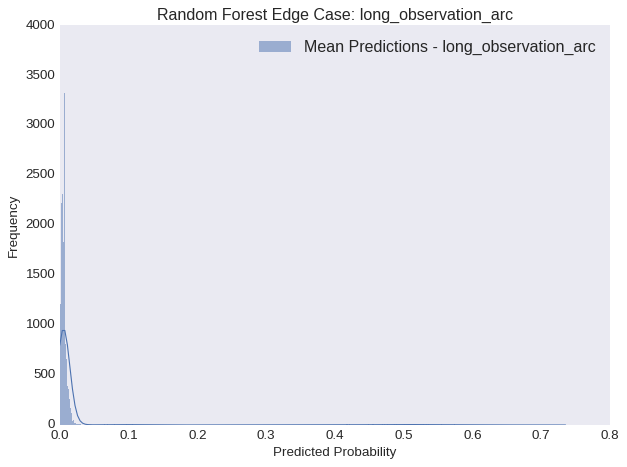


Random Forest Edge Case: high_uncertainty
Mean Predictions: count    135499.000000
mean          0.027354
std           0.092833
min           0.000000
25%           0.004500
50%           0.007800
75%           0.011900
max           0.736600
dtype: float64
Prediction Standard Deviations: count    135499.000000
mean          0.022655
std           0.025207
min           0.000000
25%           0.013919
50%           0.017810
75%           0.021768
max           0.238298
dtype: float64


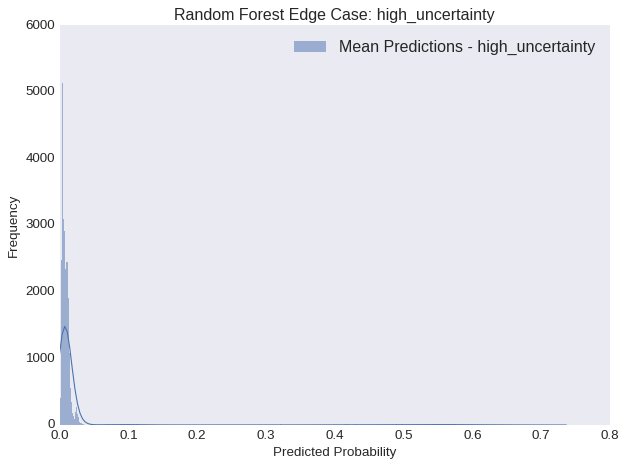

In [ ]:
# Run Monte Carlo for Random Forest
rf_edge_case_results = monte_carlo_extended_cases(rf_model, X_test_scaled, feature_columns=X_test.columns)

# Analyze Results
for condition, result in rf_edge_case_results.items():
    mean_predictions = result.mean(axis=1)
    std_predictions = result.std(axis=1)
    print(f"\nRandom Forest Edge Case: {condition}")
    print(f"Mean Predictions: {mean_predictions.describe()}")
    print(f"Prediction Standard Deviations: {std_predictions.describe()}")

In [ ]:
    # Visualize Mean Predictions
    plt.figure(figsize=(8,6))
    sns.histplot(mean_predictions, kde=True, label=f'Mean Predictions - {condition}')
    plt.title(f'Random Forest Edge Case: {condition}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

### 12.2.2 XGBoost Simulation

In [ ]:
# Run Monte Carlo for XGBoost
xgb_edge_case_results = monte_carlo_extended_cases(xgb_model, X_test_scaled, feature_columns=X_test.columns)

# Analyze Results
for condition, result in xgb_edge_case_results.items():
    mean_predictions = result.mean(axis=1)
    std_predictions = result.std(axis=1)
    print(f"\nXGBoost Edge Case: {condition}")
    print(f"Mean Predictions: {mean_predictions.describe()}")
    print(f"Prediction Standard Deviations: {std_predictions.describe()}")

Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied successfully.
Condition 'low_moid': Modifier applied success

KeyboardInterrupt: 

In [ ]:
    # Visualize Mean Predictions
    plt.figure(figsize=(8,6))
    sns.histplot(mean_predictions, kde=True, label=f'Mean Predictions - {condition}')
    plt.title(f'XGBoost Edge Case: {condition}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()